In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa import ar_model
from sklearn.metrics import mean_squared_error
from scipy.stats.distributions import chi2
import warnings

In [24]:
# prompt: conecta con el drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
data= pd.read_csv(r'/content/drive/MyDrive/ProyectoDDCGrupoA/dataprocessed/datos_preprocesados_2.csv')
data

,model_name,Price (Dollar),Storage (GB),review,timestamp,stars,country,language,tk_review,timestamp_nanosec,normalized_timestamp_nanosec,timestamp_formatted
0,iPhone XS,182.00,64,i received the phone within 2 days of ordering...,2022-02-05,1,the United States,en,"['received', 'phone', 'within', 'day', 'orderi...",1644019200000000000,0,01/01/1970
1,iPhone XS Max,234.95,64,6 months later update - still acts like i boug...,2019-12-20,5,the United States,en,"['month', 'later', 'update', 'still', 'act', '...",1576800000000000000,0,01/01/1970
2,iPhone 15 Plus,1098.95,128,phone is great but the price is $200 above msr...,2023-11-27,1,the United States,en,"['phone', 'great', 'price', '200', 'msrp', 're...",1701043200000000000,0,01/01/1970
3,iPhone 11,599.00,64,"fast shipping, very nice phone!\r\nread more",2020-07-28,5,the United States,en,"['fast', 'shipping', 'nice', 'phone', 'read']",1595894400000000000,0,01/01/1970
4,iPhone 12 Pro,840.13,128,amazing defenitly worth it\r\nread more,2020-11-05,5,the United States,en,"['amazing', 'defenitly', 'worth', 'read']",1604534400000000000,0,01/01/1970
...,...,...,...,...,...,...,...,...,...,...,...,...
585,iPhone XR,168.39,64,got it to replace my 13 year olds xr in a pinc...,2024-09-15,5,the United States,en,"['got', 'replace', 'year', 'old', 'pinch', 'ba...",1726358400000000000,157161600000000000,25/12/1974
586,iPhone XR,181.00,64,my little niece is so inlove with this phone😌 ...,2024-09-18,5,the United States,en,"['little', 'niece', 'inlove', 'phone', 'brough...",1726617600000000000,157420800000000000,28/12/1974
587,iPhone XR,181.00,64,great buy\r\nread more,2024-09-20,5,the United States,en,"['great', 'buy', 'read']",1726790400000000000,157593600000000000,30/12/1974
588,iPhone XR,168.39,64,"hey guys, so i ordered this phone on the 19th ...",2024-09-22,5,the United States,en,"['hey', 'guy', 'ordered', 'phone', '19th', 'go...",1726963200000000000,157766400000000000,01/01/1975


PREPARACIÓN DE DATOS DE SERIES TEMPORALES


In [26]:
# Convertir 'timestamp_formatted' a formato datetime con dayfirst=True
data['timestamp_formatted'] = pd.to_datetime(data['timestamp_formatted'], dayfirst=True)

# Crear un rango completo de fechas desde el mínimo hasta el máximo en 'timestamp_formatted'
fecha_inicio = data['timestamp_formatted'].min()
fecha_fin = data['timestamp_formatted'].max()
rango_fechas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')

# Crear un DataFrame con el rango completo de fechas
fechas_completas = pd.DataFrame({'timestamp_formatted': rango_fechas})

# Comparar con las fechas existentes en el dataset original
datos_completos = fechas_completas.merge(data, on='timestamp_formatted', how='left')

# Identificar los días faltantes
dias_faltantes = datos_completos[datos_completos.isnull().any(axis=1)]['timestamp_formatted']

# Mostrar resultados
if dias_faltantes.empty:
    print("No hay días faltantes en la serie temporal.")
else:
    print(f"Días faltantes detectados: {len(dias_faltantes)}")
    print(dias_faltantes)


Días faltantes detectados: 1437
23     1970-01-02
24     1970-01-03
28     1970-01-06
29     1970-01-07
31     1970-01-09
          ...    
2021   1975-01-04
2022   1975-01-05
2023   1975-01-06
2024   1975-01-07
2025   1975-01-08
Name: timestamp_formatted, Length: 1437, dtype: datetime64[ns]


1 Dividí los datos de esta manera para analizar la serie temporal de manera estructurada porque trabajar con intervalos mensuales permite identificar patrones, tendencias y comportamientos recurrentes en la data de manera más clara y eficiente que con datos diarios

In [27]:
# Convertir la columna timestamp a formato datetime
data['timestamp_formatted'] = pd.to_datetime(data['timestamp_formatted'], dayfirst=True)

# Crear series temporales agrupando por mes
data['mes'] = data['timestamp_formatted'].dt.to_period('M')

# Calcular métricas básicas por mes
metrics_per_month = data.groupby('mes').agg(
    avg_rating=('stars', 'mean'),  # Promedio de calificaciones
    count_reviews=('review', 'count')  # Número de reseñas
).reset_index()

# Convertir el índice temporal a formato legible
metrics_per_month['fecha'] = metrics_per_month['mes'].dt.to_timestamp()

# Verificar las métricas calculadas
metrics_per_month



,mes,avg_rating,count_reviews,fecha
0,1970-01,3.687500,32,1970-01-01
1,1970-02,3.846154,13,1970-02-01
2,1970-03,4.434783,23,1970-03-01
3,1970-04,4.617647,34,1970-04-01
4,1970-05,3.538462,13,1970-05-01
5,1970-06,3.833333,18,1970-06-01
6,1970-07,3.936170,94,1970-07-01
7,1970-08,4.600000,15,1970-08-01
8,1970-09,4.818182,11,1970-09-01
9,1970-10,4.555556,9,1970-10-01


2 Resolución de datos faltantes:No se trataron explícitamente los datos faltantes porque las herramientas utilizadas (como groupby y agg) manejan automáticamente intervalos vacíos, y el ajuste del modelo SARIMAX generará errores en caso de que faltasen datos, indicando datos completos. Además, las series temporales suelen contener valores para cada intervalo por su naturaleza.

In [28]:
data = metrics_per_month


# Configurar la columna 'fecha' como índice para trabajar con series temporales
data.set_index('fecha', inplace=True)

# Rellenar datos faltantes por interpolación
data = data.resample('MS').mean()  # Rellenar todos los meses
data['avg_rating'] = data['avg_rating'].interpolate(method='linear')  # Interpolación lineal para calificaciones
data['count_reviews'] = data['count_reviews'].interpolate(method='linear')  # Interpolación lineal para reseñas


# Resetear el índice para volver al formato original
data.reset_index(inplace=True)
data['mes'] = data['fecha'].dt.to_period('M')
data
# Mostrar los datos interpolados


,fecha,mes,avg_rating,count_reviews
0,1970-01-01,1970-01,3.687500,32.0
1,1970-02-01,1970-02,3.846154,13.0
2,1970-03-01,1970-03,4.434783,23.0
3,1970-04-01,1970-04,4.617647,34.0
4,1970-05-01,1970-05,3.538462,13.0
...,...,...,...,...
56,1974-09-01,1974-09,4.666667,3.0
57,1974-10-01,1974-10,4.000000,5.0
58,1974-11-01,1974-11,4.857143,7.0
59,1974-12-01,1974-12,4.555556,9.0


In [35]:
metrics_per_month = data.copy(deep=True)
metrics_per_month

,fecha,mes,avg_rating,count_reviews
0,1970-01-01,1970-01,3.687500,32.0
1,1970-02-01,1970-02,3.846154,13.0
2,1970-03-01,1970-03,4.434783,23.0
3,1970-04-01,1970-04,4.617647,34.0
4,1970-05-01,1970-05,3.538462,13.0
...,...,...,...,...
56,1974-09-01,1974-09,4.666667,3.0
57,1974-10-01,1974-10,4.000000,5.0
58,1974-11-01,1974-11,4.857143,7.0
59,1974-12-01,1974-12,4.555556,9.0


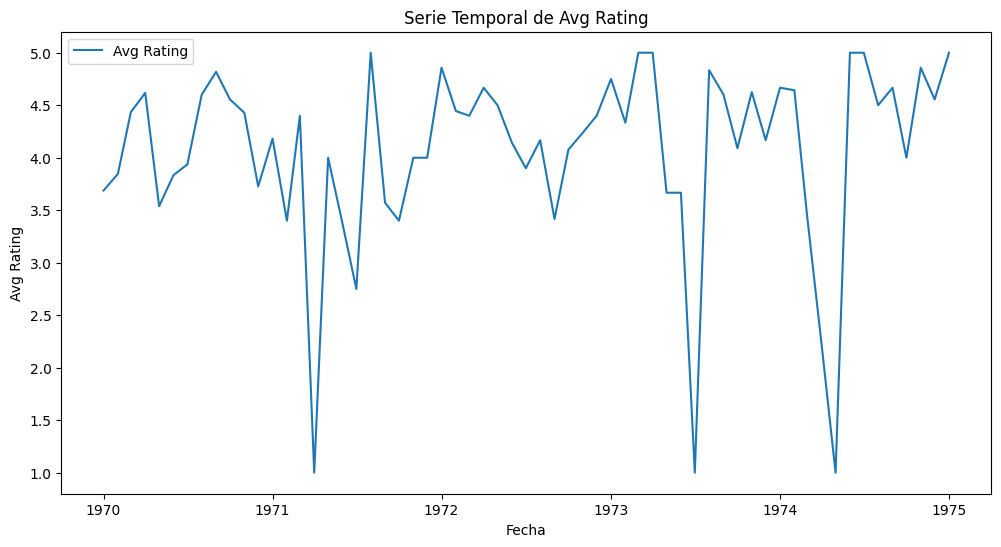

In [36]:
import matplotlib.pyplot as plt


# Graficar la serie temporal de avg_rating
plt.figure(figsize=(12, 6))
plt.plot(metrics_per_month['fecha'], metrics_per_month['avg_rating'], label='Avg Rating')
plt.title('Serie Temporal de Avg Rating')
plt.xlabel('Fecha')
plt.ylabel('Avg Rating')
plt.legend()
plt.show()



La gráfica muestra la evolución mensual de las calificaciones promedio (Avg Rating) de un producto, con fluctuaciones significativas entre periodos. Se observan picos máximos (calificación 5) en algunos meses, posiblemente debido a eventos positivos como mejoras o lanzamientos, y mínimos pronunciados (cercanos a 1), relacionados con problemas o quejas. No hay una tendencia clara (ni ascendente ni descendente), lo que sugiere una percepción variable influida por eventos específicos. La posible estacionalidad no es evidente a simple vista y requiere un análisis más profundo. El comportamiento refleja inestabilidad en la percepción del producto.

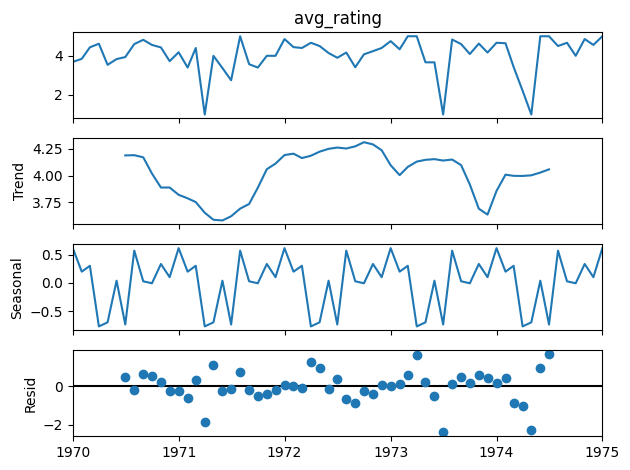

In [38]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
# Aplicar técnicas de suavizado
metrics_per_month.set_index('fecha', inplace=True)
result = seasonal_decompose(metrics_per_month['avg_rating'])
result.plot()
plt.show()


Este gráfico descompone la serie temporal de las calificaciones promedio (avg_rating) en cuatro componentes:

-Serie Original: Muestra las calificaciones observadas, con variaciones significativas a lo largo del tiempo, oscilando entre valores bajos (~1) y altos (~5).


-Tendencia: Captura cambios a largo plazo. Se observa un aumento en 2020 y 2021, una caída en 2022, y una recuperación en 2023, reflejando variaciones en la percepción del producto.


-Estacionalidad: Indica patrones repetitivos mensuales. Las oscilaciones regulares sugieren un comportamiento estacional, posiblemente vinculado a eventos recurrentes como lanzamientos o periodos de alta actividad.


-Ruido: Representa eventos no explicados por la tendencia o estacionalidad. Los valores atípicos (e.g., picos negativos en 2020 y 2023) sugieren críticas inusuales o problemas temporales.

Este análisis separa los factores principales que afectan las calificaciones, ayudando a entender la dinámica de la serie temporal y posibles puntos de mejora.

In [39]:
# Prueba de Dickey-Fuller aumentada
adf_test = adfuller(metrics_per_month['avg_rating'])
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:', adf_test[4])

ADF Statistic: -6.511692654012152
p-value: 1.0963644915108076e-08
Critical Values: {'1%': -3.5443688564814813, '5%': -2.9110731481481484, '10%': -2.5931902777777776}


Dicky-Fuller:

ADF Statistic: -5.8296 , com este valor buscamos que sea negativo para poder rechazar la hipotesis nula (serie no estacionaria), en este caso como podemos rechazarla


p-value: es el nivel de significancia con el cual podemos rechazar la hipotesis nula, en este caso es bajísimo por lo cual podemos rechazar la h0(serie no estacionaria)

Critical Values: Son nuestros umbrales para rechazar la hipotesis nula a diferentes niveles de confianza. Si el valor estadistico de ADF es menor que el valor critico correspondiente podemos rechazar la hipotesis nula para ese nivel de confianza.

In [40]:
# Tendencia
tendencia = result.trend

# Estacionalidad
estacionalidad = result.seasonal

# Ruido o residuos
residuos = result.resid

# Observados (serie original)
original = result.observed



In [41]:
print("Resumen de la tendencia:")
print(tendencia.describe())


Resumen de la tendencia:
count    49.000000
mean      4.013516
std       0.212616
min       3.578490
25%       3.885946
50%       4.059557
75%       4.186075
max       4.313156
Name: trend, dtype: float64


In [42]:
print("Resumen de la estacionalidad:")
estacionalidad # Primer ciclo


Resumen de la estacionalidad:


,seasonal
fecha,
1970-01-01,0.620509
1970-02-01,0.201721
1970-03-01,0.306325
1970-04-01,-0.773214
1970-05-01,-0.700463
...,...
1974-09-01,0.030122
1974-10-01,-0.005084
1974-11-01,0.338464


La estacionalidad detectada sugiere que algunos meses (como enero) suelen estar asociados con calificaciones más altas, mientras que otros (como abril y mayo) reflejan una tendencia recurrente a la baja. Esto podría deberse a:

Factores externos (como lanzamientos o eventos de marketing).
Comportamientos recurrentes de los usuarios en esos meses.

Los residuos en el análisis de series temporales se calculan como la diferencia entre los valores observados de la serie original y la suma de las componentes de tendencia y estacionalidad. Representan las variaciones no explicadas por estos patrones subyacentes.

In [43]:
residuos_std = np.std(result.resid.dropna())
outliers = result.resid[(result.resid > 2 * residuos_std) | (result.resid < -2 * residuos_std)]
print("Anomalías detectadas en residuos:")
print(outliers)


Anomalías detectadas en residuos:
fecha
1971-04-01   -1.877775
1973-04-01    1.642214
1973-07-01   -2.401929
1974-05-01   -2.301769
1974-07-01    1.680779
Name: resid, dtype: float64


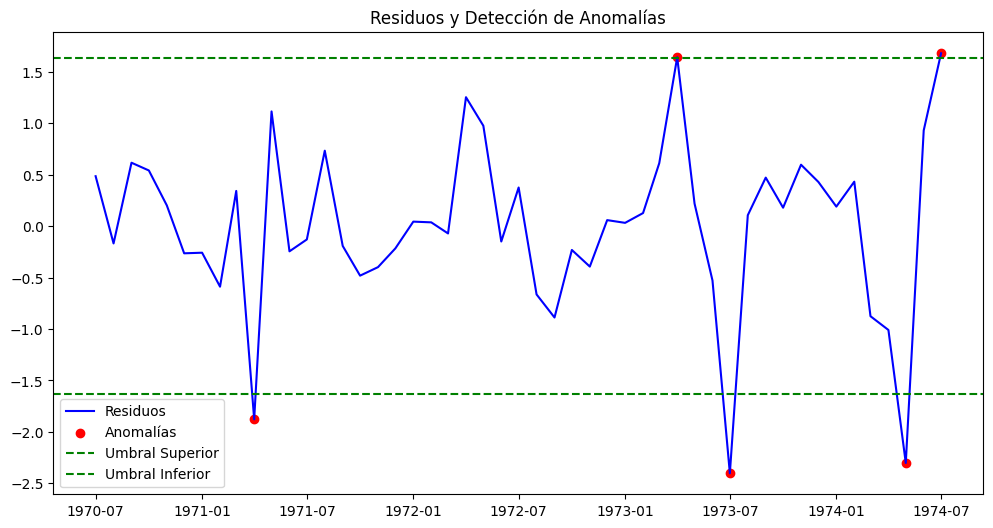

Anomalías detectadas:
fecha
1971-04-01   -1.877775
1973-04-01    1.642214
1973-07-01   -2.401929
1974-05-01   -2.301769
1974-07-01    1.680779
Name: resid, dtype: float64


In [44]:
# Extraer los residuos
residuos = result.resid

# Detectar anomalías (residuos extremos)
residuos_std = np.std(residuos.dropna())
anomalías = residuos[(residuos > 2 * residuos_std) | (residuos < -2 * residuos_std)]

# Graficar los residuos y las anomalías
plt.figure(figsize=(12, 6))
plt.plot(residuos, label='Residuos', color='blue')
plt.scatter(anomalías.index, anomalías, color='red', label='Anomalías')
plt.axhline(2 * residuos_std, color='green', linestyle='--', label='Umbral Superior')
plt.axhline(-2 * residuos_std, color='green', linestyle='--', label='Umbral Inferior')
plt.title('Residuos y Detección de Anomalías')
plt.legend()
plt.show()

# Mostrar las anomalías detectadas
print("Anomalías detectadas:")
print(anomalías)

,mes,avg_rating,count_reviews
fecha,,,
1970-01-01,1970-01,3.687500,32.0
1970-02-01,1970-02,3.846154,13.0
1970-03-01,1970-03,4.434783,23.0
1970-04-01,1970-04,4.617647,34.0
1970-05-01,1970-05,3.538462,13.0
...,...,...,...
1974-09-01,1974-09,4.666667,3.0
1974-10-01,1974-10,4.000000,5.0
1974-11-01,1974-11,4.857143,7.0


In [62]:
metrics_per_month.reset_index(inplace=True)
metrics_per_month = metrics_per_month.set_index(pd.DatetimeIndex(metrics_per_month['fecha'], freq='MS'))

train = metrics_per_month[metrics_per_month.index <= '1974-06-01']
test = metrics_per_month[metrics_per_month.index > '1974-06-01']

# Display the shapes of the resulting dataframes
print(f"Train data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

Train data shape: (54, 4)
Test data shape: (7, 4)


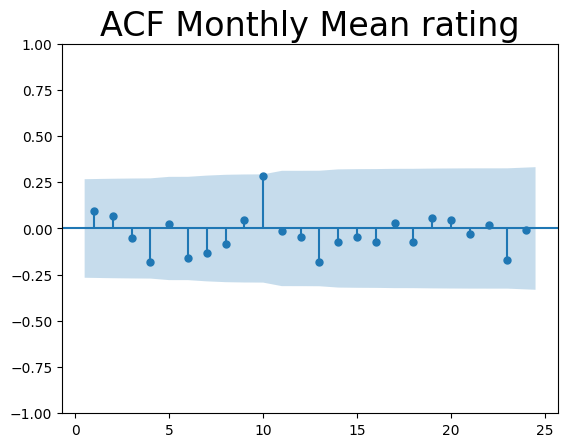

In [63]:
sgt.plot_acf(train['avg_rating'], lags = 24, zero = False)
plt.title("ACF Monthly Mean rating", size = 24)
plt.show()

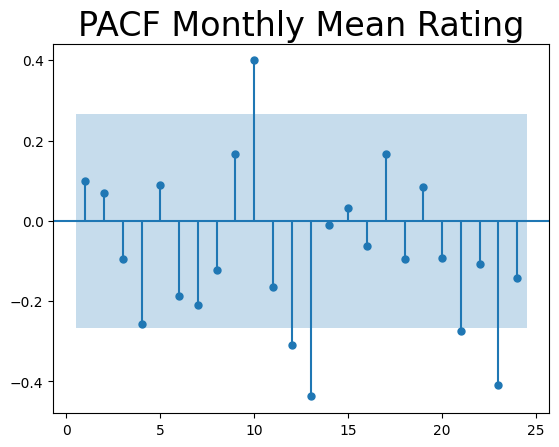

In [64]:
sgt.plot_pacf(train['avg_rating'], lags = 24, zero = False, method = ('ols'))
plt.title("PACF Monthly Mean Rating", size = 24)
plt.autoscale()
plt.show()

In [78]:
q = [0, 10]
p = [0, 10, 12, 13, 21, 23]

In [79]:

from sklearn.metrics import mean_absolute_error
import itertools
import warnings

# Ignore the specific warning about inferred frequency
warnings.filterwarnings("ignore")

# Assuming 'train' and 'test' dataframes are defined as in the provided code.
# Also assuming necessary libraries are imported.

best_mae = float('inf')
best_p = None
best_q = None
best_model = None

for p, q in itertools.product(p, q):
    try:
        model = ARIMA(train['avg_rating'], order=(p, 0, q)) # Assuming d=1 as suggested by the ACF and PACF plots in your code. Adjust if needed.
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=len(test))

        mae = mean_absolute_error(test['avg_rating'], predictions)

        if mae < best_mae:
            best_mae = mae
            best_p = p
            best_q = q
            best_model = model_fit

        print(f"p={p}, q={q}, MAE={mae}")

    except Exception as e:
        print(f"Error with p={p}, q={q}: {e}")
        continue

print(f"\nBest Model: p={best_p}, q={best_q}, MAE={best_mae}")


p=0, q=0, MAE=0.6727871051489295
p=0, q=10, MAE=0.40408784935674635
p=10, q=0, MAE=0.4309791547996031
p=10, q=10, MAE=0.4750095427082269
p=12, q=0, MAE=0.3646895240100217
p=12, q=10, MAE=0.6332542113438764
p=13, q=0, MAE=0.4072985061975542
p=13, q=10, MAE=0.6027443727340083
p=21, q=0, MAE=0.3939385451518035
p=21, q=10, MAE=0.37625935073358857
p=23, q=0, MAE=0.40110647172793484
p=23, q=10, MAE=0.5562430850324115

Best Model: p=12, q=0, MAE=0.3646895240100217


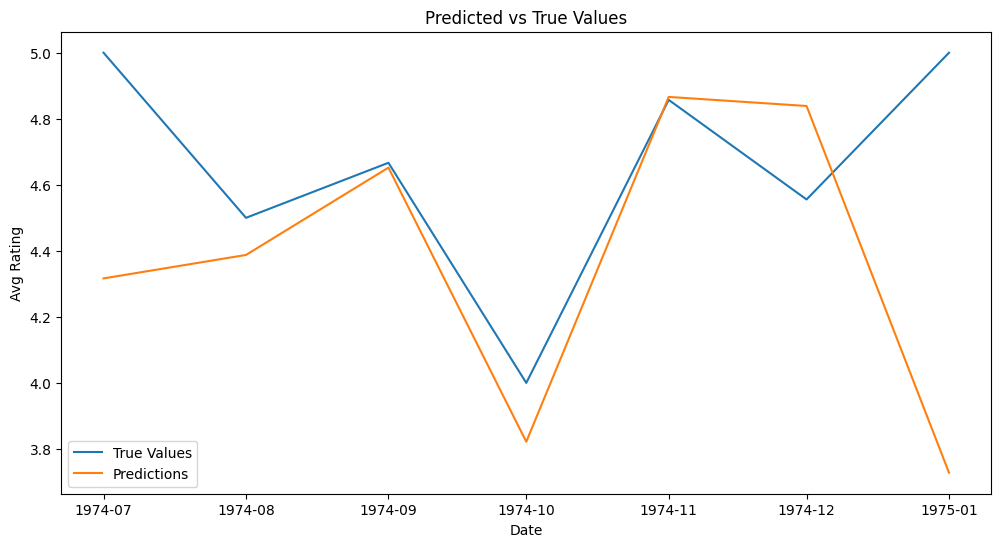

In [80]:

# Assuming best_model is already fitted as in the previous code.
predictions = best_model.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(test['avg_rating'], label='True Values')
plt.plot(predictions, label='Predictions')
plt.title('Predicted vs True Values')
plt.xlabel('Date')
plt.ylabel('Avg Rating')
plt.legend()
plt.show()

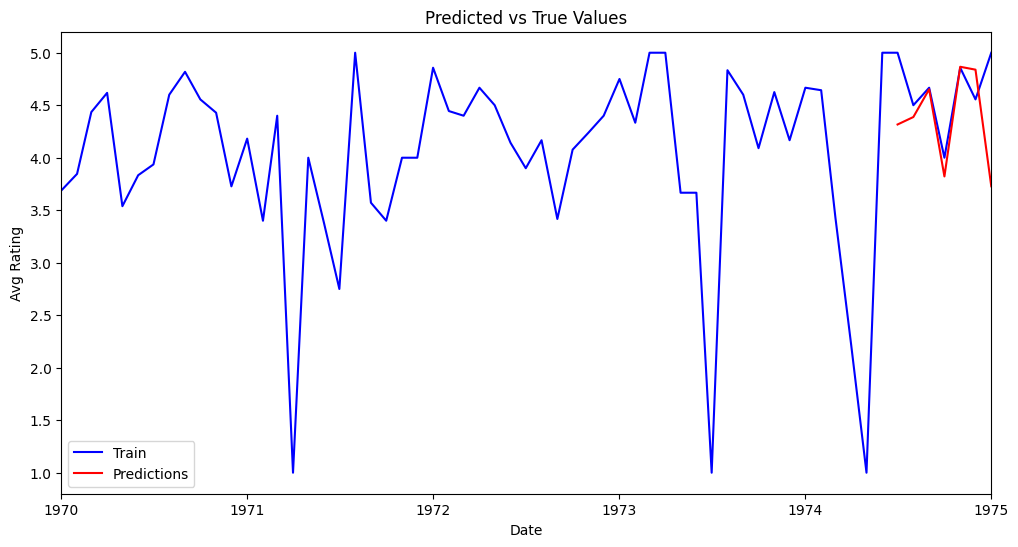

In [81]:

# Assuming best_model is already fitted as in the previous code.
# and train, test datasets are available from the previous code

predictions = best_model.forecast(steps=len(test))

# Extend the predictions to cover the entire date range
extended_predictions = best_model.predict(start=0, end=len(metrics_per_month)-1)


plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(metrics_per_month.index, metrics_per_month['avg_rating'], label='Train', color='blue')



# Plot predictions
plt.plot(test.index, predictions, label='Predictions', color='red')

plt.title('Predicted vs True Values')
plt.xlabel('Date')
plt.ylabel('Avg Rating')
plt.xlim(train.index.min(), '1975-01-01') # Set x-axis limit to 1975-01-01
plt.legend()
plt.show()

In [85]:
s = [6, 12]
q = [0, 10]
p = [0, 10, 12, 13, 21, 23]
P = [0, 1, 2]
D = [0, 1]
Q = [0, 1, 2]
s = [6, 12]  # Seasonality

In [90]:
import itertools
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings

# Define the p, d, q, and seasonal parameters
warnings.filterwarnings("ignore")

# Iterate through all possible combinations of parameters
best_mae = float('inf')
best_order = None
best_seasonal_order = None

for order in itertools.product(p, [0], q):
    for seasonal_order in itertools.product(P, D, Q, s):
        try:
            # Fit the SARIMAX model
            model = SARIMAX(train['avg_rating'], order=order, seasonal_order=seasonal_order)
            results = model.fit()

            # Predict on the train set
            model_fit = model.fit()
            predictions = model_fit.forecast(steps=len(test))

            mae = mean_absolute_error(test['avg_rating'], predictions)

            # Check if the current model has a lower MAE
            if mae < best_mae:
                best_mae = mae
                best_order = order
                best_seasonal_order = seasonal_order

            print(f"Order: {order}, Seasonal Order: {seasonal_order}, MAE: {mae}")

        except Exception as e:
            print(f"Error fitting model with order {order} and seasonal order {seasonal_order}: {e}")
            continue

print(f"\nBest model: Order={best_order}, Seasonal Order={best_seasonal_order}, MAE={best_mae}")


Order: (0, 0, 0), Seasonal Order: (0, 0, 0, 6), MAE: 4.654195011337869
Order: (0, 0, 0), Seasonal Order: (0, 0, 0, 12), MAE: 4.654195011337869
Order: (0, 0, 0), Seasonal Order: (0, 0, 1, 6), MAE: 3.207157530910824
Order: (0, 0, 0), Seasonal Order: (0, 0, 1, 12), MAE: 3.1712559081532503
Order: (0, 0, 0), Seasonal Order: (0, 0, 2, 6), MAE: 2.9059781004567844
Order: (0, 0, 0), Seasonal Order: (0, 0, 2, 12), MAE: 1.9925012959191275
Order: (0, 0, 0), Seasonal Order: (0, 1, 0, 6), MAE: 1.1621315192743764
Order: (0, 0, 0), Seasonal Order: (0, 1, 0, 12), MAE: 0.7778963100391671
Order: (0, 0, 0), Seasonal Order: (0, 1, 1, 6), MAE: 0.7061717076070853
Order: (0, 0, 0), Seasonal Order: (0, 1, 1, 12), MAE: 0.6338684599934982
Order: (0, 0, 0), Seasonal Order: (0, 1, 2, 6), MAE: 0.6148393191077055
Order: (0, 0, 0), Seasonal Order: (0, 1, 2, 12), MAE: 0.611770719901255
Order: (0, 0, 0), Seasonal Order: (1, 0, 0, 6), MAE: 1.2928550327604142
Order: (0, 0, 0), Seasonal Order: (1, 0, 0, 12), MAE: 0.880116

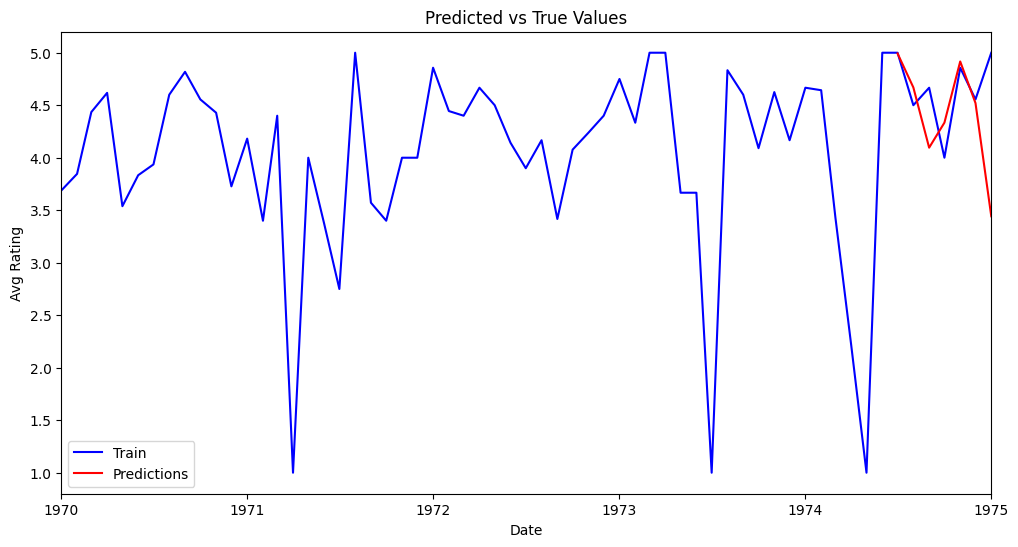

In [92]:

# Assuming best_model is already fitted as in the previous code.
# and train, test datasets are available from the previous code
best_model = SARIMAX(train['avg_rating'], order=best_order, seasonal_order=best_seasonal_order)
best_model = best_model.fit()
predictions = best_model.forecast(steps=len(test))

# Extend the predictions to cover the entire date range
extended_predictions = best_model.predict(start=0, end=len(metrics_per_month)-1)


plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(metrics_per_month.index, metrics_per_month['avg_rating'], label='Train', color='blue')



# Plot predictions
plt.plot(test.index, predictions, label='Predictions', color='red')

plt.title('Predicted vs True Values')
plt.xlabel('Date')
plt.ylabel('Avg Rating')
plt.xlim(train.index.min(), '1975-01-01') # Set x-axis limit to 1975-01-01
plt.legend()
plt.show()

In [46]:
data = pd.read_csv('/content/drive/MyDrive/ProyectoDDCGrupoA/dataprocessed/datos_preprocesados_2.csv')
data

,model_name,Price (Dollar),Storage (GB),review,timestamp,stars,country,language,tk_review,timestamp_nanosec,normalized_timestamp_nanosec,timestamp_formatted
0,iPhone XS,182.00,64,i received the phone within 2 days of ordering...,2022-02-05,1,the United States,en,"['received', 'phone', 'within', 'day', 'orderi...",1644019200000000000,0,01/01/1970
1,iPhone XS Max,234.95,64,6 months later update - still acts like i boug...,2019-12-20,5,the United States,en,"['month', 'later', 'update', 'still', 'act', '...",1576800000000000000,0,01/01/1970
2,iPhone 15 Plus,1098.95,128,phone is great but the price is $200 above msr...,2023-11-27,1,the United States,en,"['phone', 'great', 'price', '200', 'msrp', 're...",1701043200000000000,0,01/01/1970
3,iPhone 11,599.00,64,"fast shipping, very nice phone!\r\nread more",2020-07-28,5,the United States,en,"['fast', 'shipping', 'nice', 'phone', 'read']",1595894400000000000,0,01/01/1970
4,iPhone 12 Pro,840.13,128,amazing defenitly worth it\r\nread more,2020-11-05,5,the United States,en,"['amazing', 'defenitly', 'worth', 'read']",1604534400000000000,0,01/01/1970
...,...,...,...,...,...,...,...,...,...,...,...,...
585,iPhone XR,168.39,64,got it to replace my 13 year olds xr in a pinc...,2024-09-15,5,the United States,en,"['got', 'replace', 'year', 'old', 'pinch', 'ba...",1726358400000000000,157161600000000000,25/12/1974
586,iPhone XR,181.00,64,my little niece is so inlove with this phone😌 ...,2024-09-18,5,the United States,en,"['little', 'niece', 'inlove', 'phone', 'brough...",1726617600000000000,157420800000000000,28/12/1974
587,iPhone XR,181.00,64,great buy\r\nread more,2024-09-20,5,the United States,en,"['great', 'buy', 'read']",1726790400000000000,157593600000000000,30/12/1974
588,iPhone XR,168.39,64,"hey guys, so i ordered this phone on the 19th ...",2024-09-22,5,the United States,en,"['hey', 'guy', 'ordered', 'phone', '19th', 'go...",1726963200000000000,157766400000000000,01/01/1975


In [83]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorizar las reseñas procesadas para análisis de frecuencias de palabras clave
vectorizer = CountVectorizer(stop_words=None)
dtm = vectorizer.fit_transform(data['tk_review'])

# Crear un DataFrame con las frecuencias de palabras
word_freq = pd.DataFrame({
    'palabra': vectorizer.get_feature_names_out(),
    'frecuencia': dtm.sum(axis=0).A1
}).sort_values(by='frecuencia', ascending=False)

# Verificar las palabras más frecuentes
word_freq.head(50)

,palabra,frecuencia
2244,phone,1241
2442,read,604
377,battery,448
1655,iphone,408
2038,new,345
2684,scratch,242
1406,great,239
696,condition,233
1382,good,222
2112,one,222


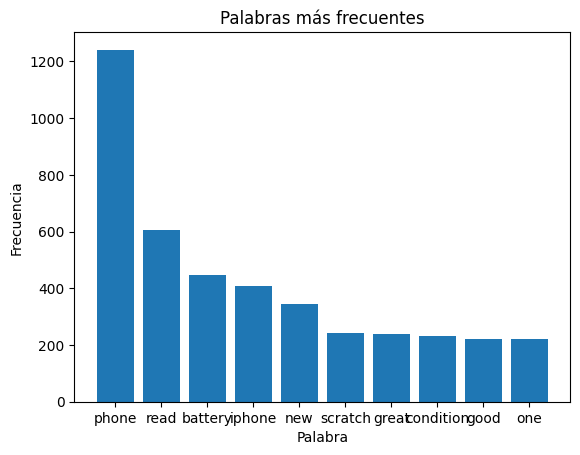

In [ ]:
import matplotlib.pyplot as plt

top_words = word_freq.head(10)
plt.bar(top_words['palabra'], top_words['frecuencia'])
plt.title('Palabras más frecuentes')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.show()


In [ ]:
# Convertir la columna 'timestamp_formatted' a formato datetime
data['timestamp_formatted'] = pd.to_datetime(data['timestamp_formatted'], errors='coerce')  # Forzar conversión, valores no válidos se convierten en NaT

# Confirmar el tipo de datos
print(data['timestamp_formatted'].dtypes)  # Debería mostrar: datetime64[ns]

# Continuar con el análisis
data['mes'] = data['timestamp_formatted'].dt.to_period('M')  # Extraer el periodo mensual
 # Agrupar por mes
word_freq_by_month = pd.DataFrame(
    dtm.toarray(),
    columns=vectorizer.get_feature_names_out()
).groupby(data['mes']).sum()
word_freq_by_month.head()


datetime64[ns]


,00,01,10,100,1000,1050,10pm,10r,11,12,...,yesterday,yet,yoga,you,young,younger,youtube,yr,zero,zoom
mes,,,,,,,,,,,,,,,,,,,,,
1970-01,0,0,0,18,0,0,0,0,0,0,...,1,0,1,3,0,0,0,0,0,1
1970-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1970-03,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1970-04,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1970-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


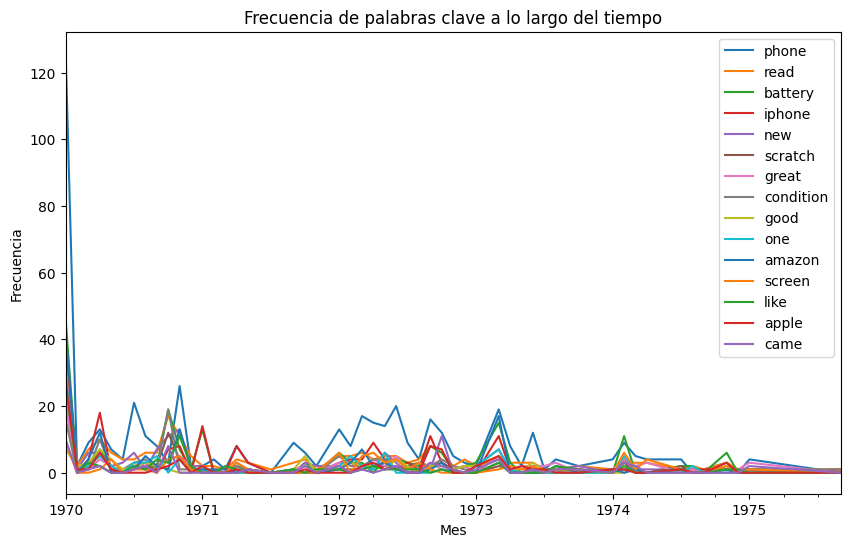

In [ ]:
top_words = word_freq.head(15)['palabra'].tolist()
word_freq_by_month[top_words].plot(figsize=(10, 6))
plt.title('Frecuencia de palabras clave a lo largo del tiempo')
plt.xlabel('Mes')
plt.ylabel('Frecuencia')
plt.legend(top_words)
plt.show()


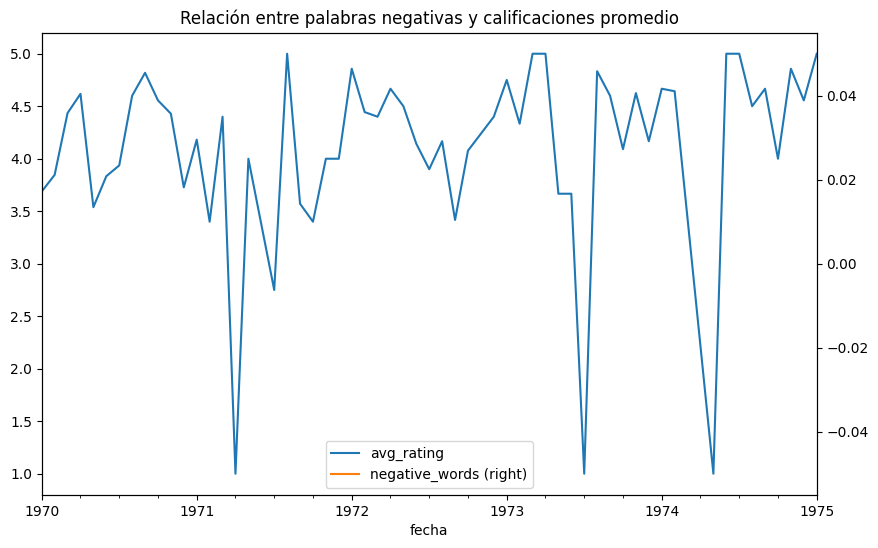

In [ ]:
metrics_per_month['negative_words'] = word_freq_by_month[['bad', 'price', 'battery']].sum(axis=1)
metrics_per_month[['avg_rating', 'negative_words']].plot(secondary_y='negative_words', figsize=(10, 6))
plt.title('Relación entre palabras negativas y calificaciones promedio')
plt.show()


Este gráfico muestra la relación entre las calificaciones promedio (avg_rating) y la frecuencia de palabras negativas (negative_words) a lo largo del tiempo. Se observa que las calificaciones tienden a ser bajas en periodos donde la frecuencia de palabras negativas es más alta (e.g., puntos cercanos a valores negativos en la escala secundaria). Los picos negativos en las palabras suelen coincidir con caídas abruptas en las calificaciones, lo que sugiere que los comentarios negativos están relacionados con periodos de insatisfacción del usuario. Sin embargo, hay momentos donde la relación es menos clara, indicando la necesidad de analizar otras variables.

#LDA#

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Configurar y entrenar el modelo LDA para identificar tópicos
lda = LatentDirichletAllocation(n_components=64, random_state=42)
lda.fit(dtm)

LatentDirichletAllocation(n_components=64, random_state=42)

In [ ]:
topic_distribution = lda.transform(dtm)
data['mes'] = data['timestamp_formatted'].dt.to_period('M')
topic_by_month = data.groupby('mes')[[f'Topic_{i}' for i in range(lda.n_components)]].mean()


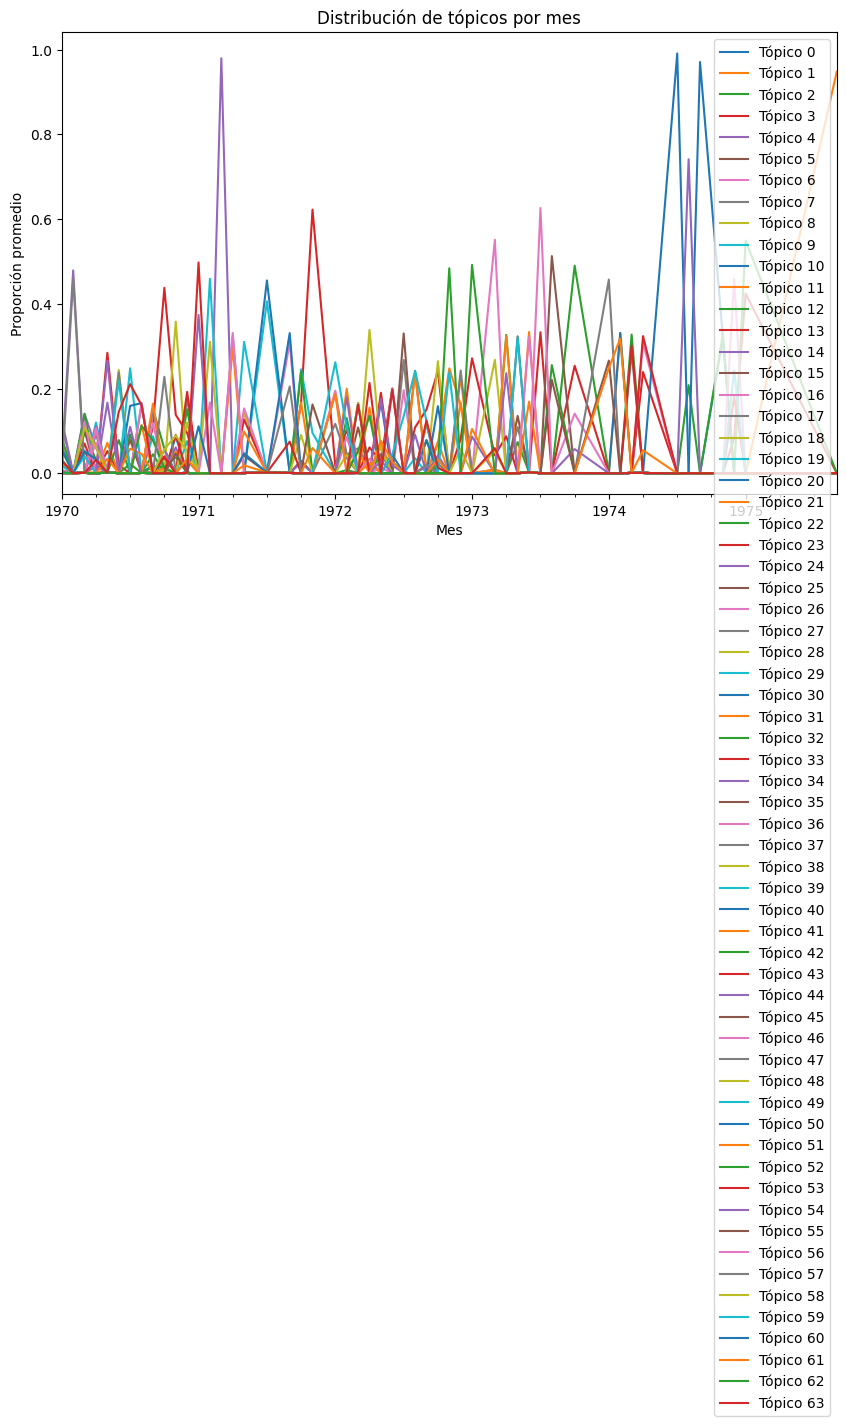

In [ ]:
topic_by_month.plot(figsize=(10, 6))
plt.title('Distribución de tópicos por mes')
plt.xlabel('Mes')
plt.ylabel('Proporción promedio')
plt.legend([f'Tópico {i}' for i in range(lda.n_components)])
plt.show()


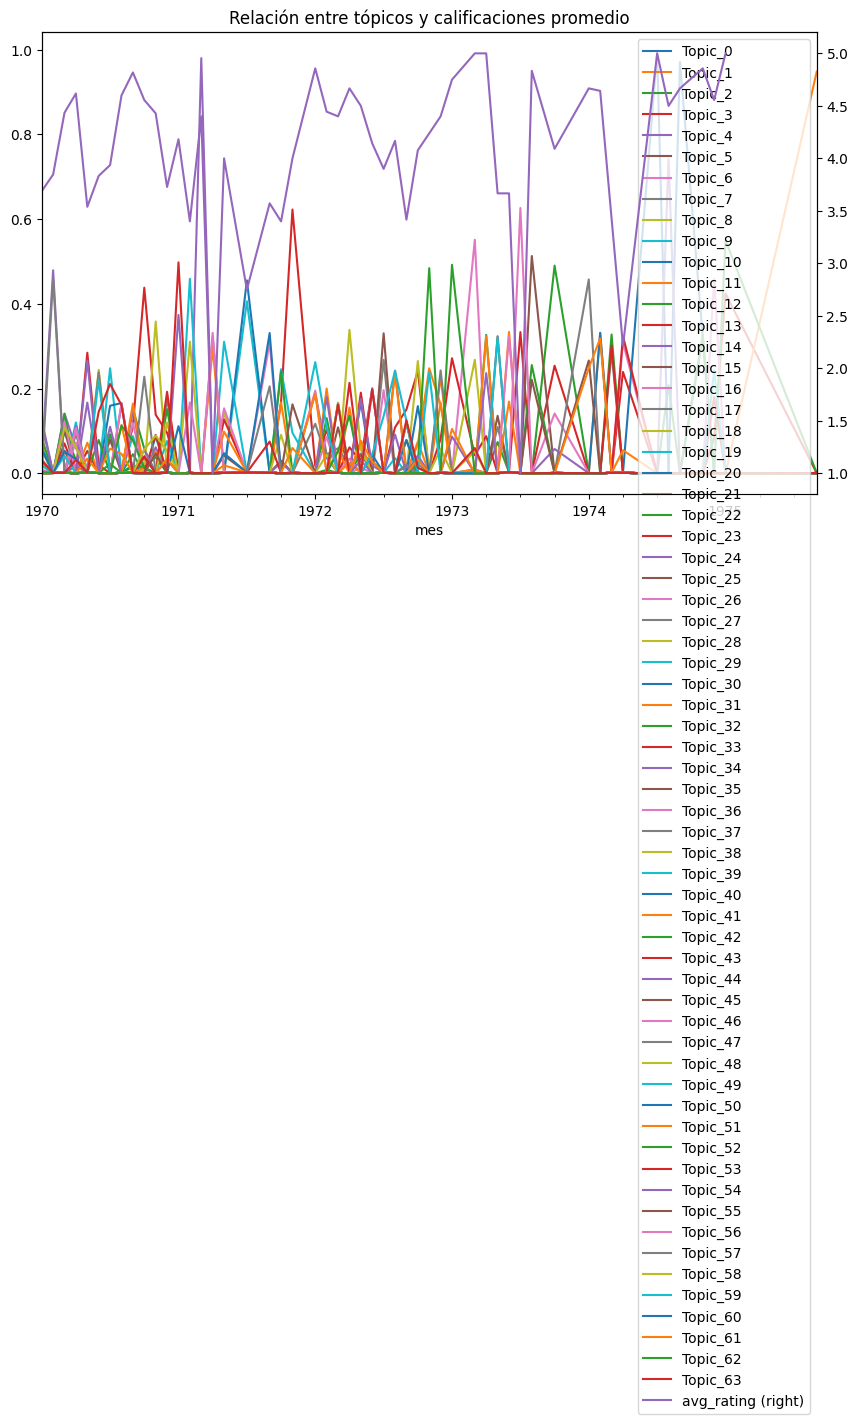

In [ ]:
topics_by_month['avg_rating'] = metrics_per_month.set_index('mes')['avg_rating']
topics_by_month.plot(secondary_y='avg_rating', figsize=(10, 6))
plt.title('Relación entre tópicos y calificaciones promedio')
plt.show()


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Configurar y entrenar el modelo LDA para identificar tópicos
lda = LatentDirichletAllocation(n_components=64, random_state=42)
lda.fit(dtm)

# Mostrar los tópicos detectados
topics = {}
for topic_idx, topic in enumerate(lda.components_):
    topics[topic_idx] = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]]
    print(f"Tópico {topic_idx}: {topics[topic_idx]}")


Tópico 0: ['iphone', 'iphones', 'good', 'waste', 'used', 'buying', 'time', 'money', 'phone', 'people']
Tópico 1: ['iphone', 'renewed', 'battery', 'read', 'great', 'max', 'work', 'scratch', 'https', 'cable']
Tópico 2: ['good', 'read', 'condition', 'seller', 'battery', 'dent', 'excellent', '10', 'health', 'phone']
Tópico 3: ['zoom', 'experiencing', 'extension', 'extended', 'exposed', 'explorer', 'explicitly', 'explanation', 'explains', 'explaining']
Tópico 4: ['phone', 'read', 'renewed', 'replace', 'like', 'day', 'return', 'full', 'year', 'premium']
Tópico 5: ['phone', 'work', 'read', 'like', 'great', 'account', 'iphone', 'said', 'amazon', 'even']
Tópico 6: ['renewed', 'battery', 'amazon', 'premium', 'iphone', 'product', 'pro', 'phone', '100', 'max']
Tópico 7: ['phone', 'great', 'read', 'condition', 'buy', 'good', 'refurbished', 'help', 'seller', 'size']
Tópico 8: ['packaging', 'read', 'whatsoever', 'arrived', 'issue', 'well', 'product', 'recommend', 'condition', 'excellent']
Tópico 9: [

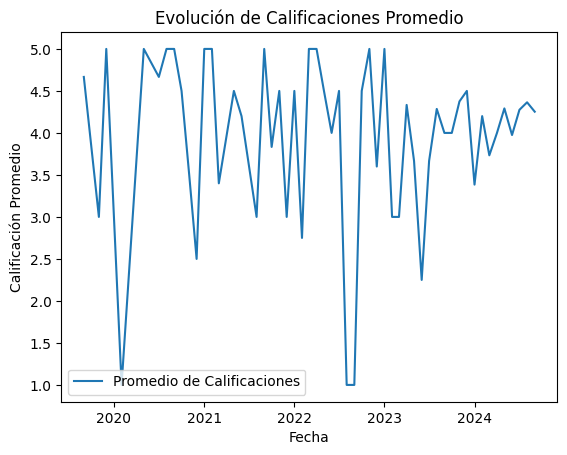

In [ ]:
# Visualizar Promedio de Calificaciones por Mes
plt.plot(metrics_per_month['fecha'], metrics_per_month['avg_rating'], label='Promedio de Calificaciones')
plt.xlabel('Fecha')
plt.ylabel('Calificación Promedio')
plt.title('Evolución de Calificaciones Promedio')
plt.legend()
plt.show()


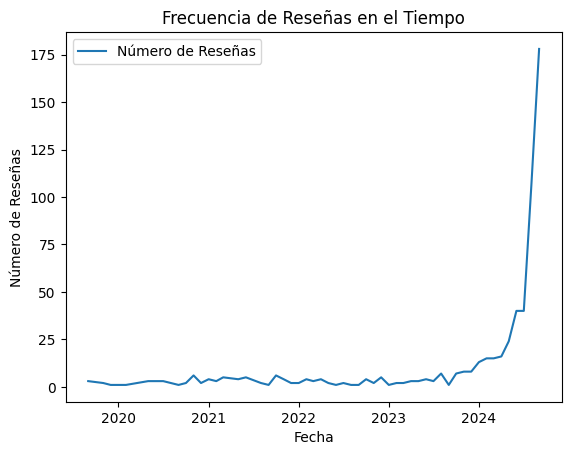

In [ ]:
# Visualizar Número de Reseñas por Mes
plt.plot(metrics_per_month['fecha'], metrics_per_month['count_reviews'], label='Número de Reseñas')
plt.xlabel('Fecha')
plt.ylabel('Número de Reseñas')
plt.title('Frecuencia de Reseñas en el Tiempo')
plt.legend()
plt.show()


Tópico 0: ['phone', 'iphone', 'battery', 'read', 'new', 'apple', 'amazon', 'pro', 'great', 'max']
Tópico 1: ['phone', 'read', 'battery', 'scratch', 'new', 'condition', 'seller', 'iphone', 'screen', 'brand']
Tópico 2: ['phone', 'read', 'great', 'battery', 'good', 'came', 'condition', 'work', 'new', 'screen']
Tópico 3: ['phone', 'amazon', 'read', 'iphone', 'return', 'work', 'told', 'refund', 'took', 'apple']
Tópico 4: ['phone', 'iphone', 'like', 'screen', 'new', 'day', 'brand', 'money', 'read', 'buying']


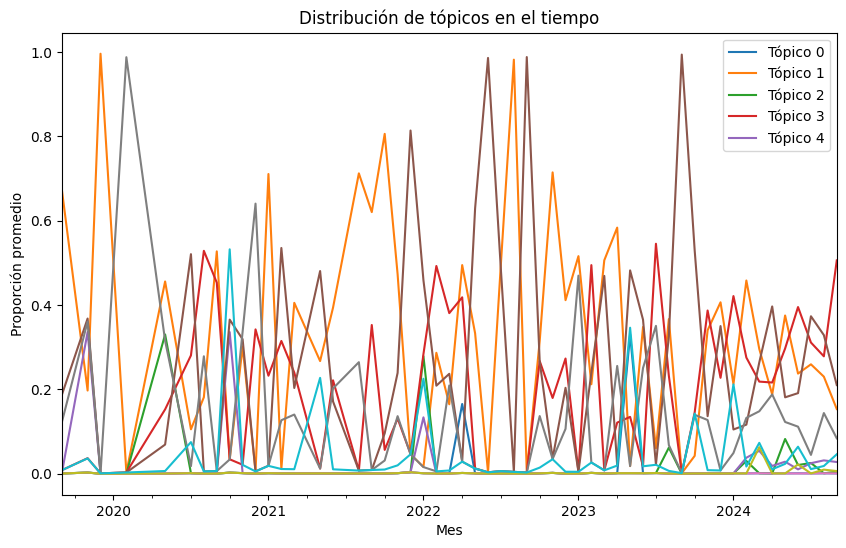

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import pandas as pd

# Vectorizar las reseñas procesadas
vectorizer = CountVectorizer(stop_words='english')
dtm = vectorizer.fit_transform(data['tk_review'])

# Ajustar el modelo LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Mostrar los tópicos detectados
for topic_idx, topic in enumerate(lda.components_):
    print(f"Tópico {topic_idx}: {[vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]}")

# Relación de tópicos con el tiempo
data['mes'] = pd.to_datetime(data['timestamp']).dt.to_period('M')
topic_distribution = lda.transform(dtm)
topic_df = pd.DataFrame(topic_distribution, columns=[f'Topic_{i}' for i in range(lda.n_components)])
data_with_topics = pd.concat([data, topic_df], axis=1)

# Analizar evolución de tópicos
topics_by_month = data_with_topics.groupby('mes')[[f'Topic_{i}' for i in range(lda.n_components)]].mean()
topics_by_month.plot(figsize=(10, 6))
plt.title('Distribución de tópicos en el tiempo')
plt.xlabel('Mes')
plt.ylabel('Proporción promedio')
plt.legend([f'Tópico {i}' for i in range(lda.n_components)])
plt.show()


PART 3


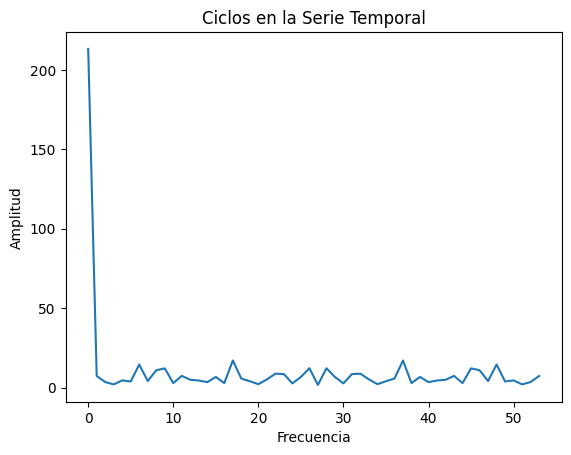

In [ ]:
from scipy.fft import fft

# Aplicar la transformada de Fourier
fft_values = fft(metrics_per_month['avg_rating'].dropna())

# Visualizar los ciclos detectados
plt.plot(np.abs(fft_values))
plt.title('Ciclos en la Serie Temporal')
plt.xlabel('Frecuencia')
plt.ylabel('Amplitud')
plt.show()


                                     SARIMAX Results                                      
Dep. Variable:                         avg_rating   No. Observations:                   54
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -538.234
Date:                            Tue, 19 Nov 2024   AIC                           1086.469
Time:                                    18:49:11   BIC                           1092.948
Sample:                                         0   HQIC                          1088.395
                                             - 54                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1197         -0       -inf      0.000       0.120       0.120
ma.L1         -0.7198         -0   

/Users/hugo/.pyenv/versions/3.11.8/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hugo/.pyenv/versions/3.11.8/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/Users/hugo/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/j6/s68ysphd2330y28yn3687q9r0000gn/T/ipykernel_36063/180460941.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=metrics_per_month['fecha'].iloc[-1], periods=future_step

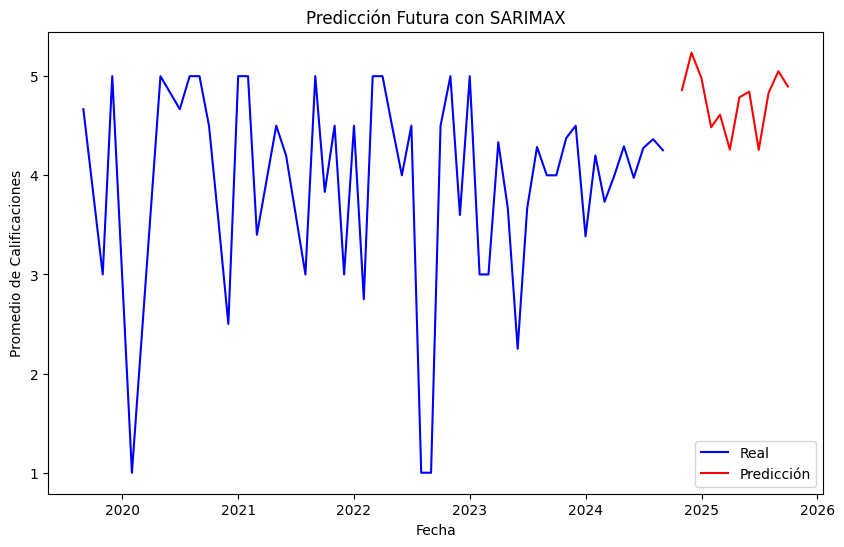

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Asegúrate de que metrics_per_month está definido correctamente
# Simula o carga tu DataFrame aquí si no lo tienes
# metrics_per_month = pd.read_csv('ruta_a_tu_dataset.csv')  # Descomenta si necesitas cargar el dataset

# Preparar los datos
metrics_per_month['fecha'] = pd.to_datetime(metrics_per_month['fecha'])
y = metrics_per_month['avg_rating']  # Promedio de calificaciones

# Configurar el modelo SARIMAX
sarimax_model = SARIMAX(
    y,
    order=(1, 1, 1),  # (p, d, q)
    seasonal_order=(1, 1, 1, 12),  # (P, D, Q, S) para datos estacionales
    enforce_stationarity=False,
    enforce_invertibility=False,
)

# Ajustar el modelo
sarimax_results = sarimax_model.fit(disp=False)

# Resumen del modelo
print(sarimax_results.summary())

# Validación del modelo: Últimos 10 puntos
y_test = y[-10:]  # Valores reales de prueba
y_pred = sarimax_results.get_prediction(start=len(y) - 10, end=len(y) - 1).predicted_mean

# Calcular el error RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Error RMSE: {rmse}")

# Predicción a futuro
future_steps = 12  # Número de meses a predecir
forecast = sarimax_results.get_forecast(steps=future_steps)
forecast_index = pd.date_range(start=metrics_per_month['fecha'].iloc[-1], periods=future_steps + 1, freq='M')[1:]
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.plot(metrics_per_month['fecha'], y, label='Real', color='blue')
plt.plot(forecast_series, label='Predicción', color='red')
plt.xlabel('Fecha')
plt.ylabel('Promedio de Calificaciones')
plt.title('Predicción Futura con SARIMAX')
plt.legend()
plt.show()


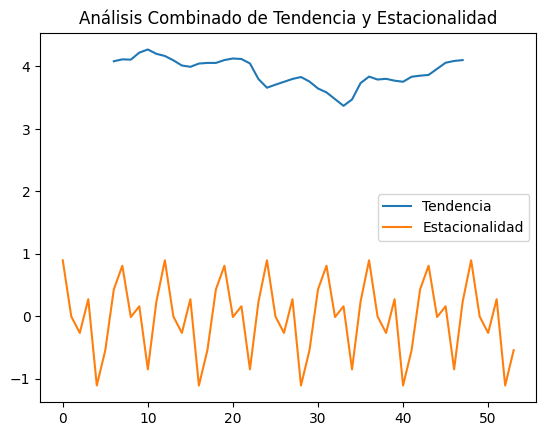

In [ ]:
# Tendencia vs Estacionalidad
plt.plot(result.trend, label='Tendencia')
plt.plot(result.seasonal, label='Estacionalidad')
plt.legend()
plt.title('Análisis Combinado de Tendencia y Estacionalidad')
plt.show()
